# Домашняя работа
1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

2. Построить случайный лес, вывести важность признаков

3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

4. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

## 1. Загрузка и подготовка данных

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv('train.csv')
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
#Находим категориальные признаки
cat_feat = list(df.dtypes[df.dtypes == object].index)

#отфильтруем непрерывные признаки
num_feat = [f for f in df if f not in (cat_feat + ['Id', 'SalePrice'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = df[cat_feat].nunique()
print(cat_nunique)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [6]:
# Создаем дамми-переменные для категорий
dummy_df = pd.get_dummies(df[cat_feat], columns=cat_feat)

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X = pd.concat([df[num_feat].fillna(-999),
                     dummy_df], axis=1)
y = df['SalePrice']

In [7]:
# разделяем данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
# приводим данные к одному масштабу
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# возвращаем к типу датафрейма
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## 2. Построить случайный лес, вывести важность признаков

In [12]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

In [16]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)   

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [22]:
# определим наиболее важные атрибуты для модели
feature_imp = pd.Series(clf_rf.feature_importances_,index=list(X.columns)).sort_values(ascending=False)

feature_imp 

OverallQual           0.422720
GrLivArea             0.123395
ExterQual_TA          0.112488
GarageCars            0.065120
1stFlrSF              0.047173
GarageArea            0.035738
BsmtQual_Ex           0.035594
KitchenQual_Ex        0.033856
TotalBsmtSF           0.030906
BsmtFinSF1            0.014816
FullBath              0.014093
YearBuilt             0.010208
LotArea               0.009948
KitchenQual_Gd        0.006500
YearRemodAdd          0.006049
2ndFlrSF              0.004203
GarageType_Attchd     0.004000
KitchenQual_TA        0.003779
GarageYrBlt           0.002993
LotShape_Reg          0.002470
ExterQual_Gd          0.002385
RoofStyle_Gable       0.001839
BedroomAbvGr          0.001778
MSZoning_RL           0.001339
TotRmsAbvGrd          0.001155
CentralAir_N          0.000941
WoodDeckSF            0.000917
Foundation_PConc      0.000822
Fireplaces            0.000802
OpenPorchSF           0.000594
                        ...   
Heating_GasW          0.000000
Heating_

In [28]:
# Оценим качество
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
# среднекравдратичная ошибка и коэффициент детерминации
print('train data')
print(mean_squared_error(y_train, clf_rf.predict(X_train)))
print(r2_score(y_train, clf_rf.predict(X_train)))
print('test data')
print(mean_squared_error(y_test, clf_rf.predict(X_test)))
print(r2_score(y_test, clf_rf.predict(X_test)))

train data
1072962060.7107935
0.831225858372021
test data
1296345455.411964
0.7904471459118744


## 3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

In [34]:
sum(X_test.isnull().sum())

0

In [23]:
train_median = df[num_feat].median()

X_train = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train[num_feat] = scaler.transform(X_train[num_feat])
X_test[num_feat] = scaler.transform(X_test[num_feat])

MSSubClass         50.0
LotFrontage        69.0
LotArea          9478.5
OverallQual         6.0
OverallCond         5.0
YearBuilt        1973.0
YearRemodAdd     1994.0
MasVnrArea          0.0
BsmtFinSF1        383.5
BsmtFinSF2          0.0
BsmtUnfSF         477.5
TotalBsmtSF       991.5
1stFlrSF         1087.0
2ndFlrSF            0.0
LowQualFinSF        0.0
GrLivArea        1464.0
BsmtFullBath        0.0
BsmtHalfBath        0.0
FullBath            2.0
HalfBath            0.0
BedroomAbvGr        3.0
KitchenAbvGr        1.0
TotRmsAbvGrd        6.0
Fireplaces          1.0
GarageYrBlt      1980.0
GarageCars          2.0
GarageArea        480.0
WoodDeckSF          0.0
OpenPorchSF        25.0
EnclosedPorch       0.0
3SsnPorch           0.0
ScreenPorch         0.0
PoolArea            0.0
MiscVal             0.0
MoSold              6.0
YrSold           2008.0
dtype: float64

In [57]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [65]:
regressor = StackingRegressor(
    [
        ('lr', KernelRidge()),
        ('dt', DecisionTreeRegressor(max_depth=5, min_samples_leaf=20, max_features=0.5)),
        ('svr', SVR())
    ],
LinearRegression())

In [66]:
regressor.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('lr',
                               KernelRidge(alpha=1, coef0=1, degree=3,
                                           gamma=None, kernel='linear',
                                           kernel_params=None)),
                              ('dt',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=5,
                                                     max_features=0.5,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=20,
                                                     min_samples_split=2,
                                    

In [69]:
# среднекравдратичная ошибка и коэффициент детерминации
print('KernelRidge')
print(mean_squared_error(y_test, regressor.named_estimators_['lr'].predict(X_test)))
print(r2_score(y_test, regressor.named_estimators_['lr'].predict(X_test)))
print('DecisionTreeRegressor')
print(mean_squared_error(y_test, regressor.named_estimators_['dt'].predict(X_test)))
print(r2_score(y_test, regressor.named_estimators_['dt'].predict(X_test)))
print('svr')
print(mean_squared_error(y_test, regressor.named_estimators_['svr'].predict(X_test)))
print(r2_score(y_test, regressor.named_estimators_['svr'].predict(X_test)))
print('StackingRegressor')
print(mean_squared_error(y_test, regressor.predict(X_test)))
print(r2_score(y_test, regressor.predict(X_test)))

KernelRidge
34001421560.027485
-4.496293369341906
DecisionTreeRegressor
1821442812.030043
0.7055657207531146
svr
6677471619.693638
-0.07940613372581695
StackingRegressor
1812741321.2480052
0.706972307416095


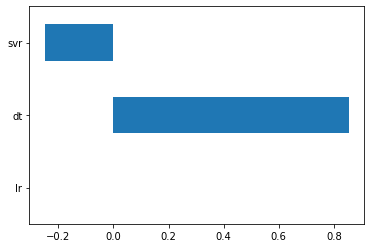

In [68]:
pd.Series(classifier.final_estimator_.coef_.flatten(), index=classifier.named_estimators_.keys()).plot(kind='barh')

У стекинга с таким набором моделей результат получился значительно хуже, чем у "случайных лесов"